# CasADi 介绍（概念 + 入门路线图）

本笔记目标：用**教程方式**把 CasADi 的核心概念串起来，理解它能做什么、不能做什么，以及最常用的 API 组合套路。

- CasADi 本质：用于 **数值优化** / **最优控制** 的建模与自动求导工具箱。
- 常见用途：非线性规划（NLP, 例如 IPOPT）、ODE/DAE 积分器（cvodes/idas）、灵敏度分析、代码生成（C 代码）。
- 重要提醒：CasADi 不是“把你现有 Python/C++ 模型直接自动求导”的万能 AD 工具；通常需要用 CasADi 的符号语法把模型**重写**出来。
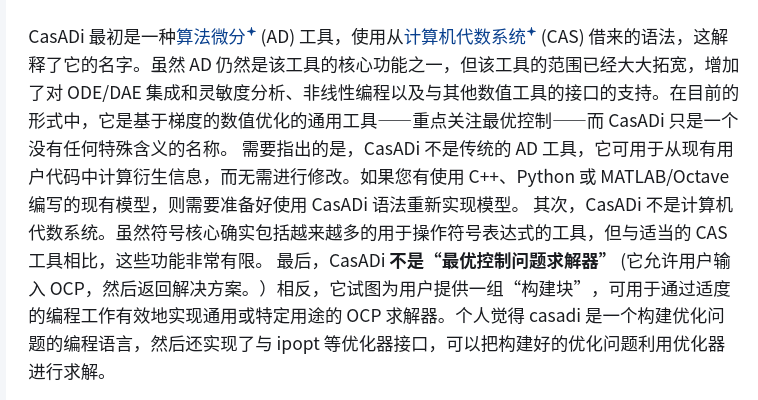

## 1. 安装与检查（Python + 系统/C++）

你现在的环境里实际上会同时出现两类 CasADi：
- **Python 包**：`pip/conda` 安装的 `casadi`（用于 Python 侧建模与求解）；
- **系统/源码安装**：安装到 `/usr/local` 的头文件 + 动态库 + 插件（用于 C++ 侧编译链接与运行）。

这两者可以共存，但要注意：**C++ 需要的是“系统级头文件/库”，不是 Python wheel。**

### 1.1 Python 安装（最简单）
- `pip install casadi`
- 或 conda 环境里安装（注意解释器与 pip 对齐）

### 1.2 Python 自检（能导入 + 能求导）
安装后建议快速自检：能导入、能求一个 Jacobian。

### 1.3 系统/C++ 自检（头文件/库/插件）
如果你是源码编译安装到 `/usr/local`，常用检查手段：
- `pkg-config --modversion casadi`（查看系统级 CasADi 版本）
- `ldconfig -p | grep casadi`（确认运行时能找到动态库）
- CMake：`find_package(casadi CONFIG REQUIRED)` 是否能找到 `casadi-config.cmake`

### 1.4 插件自检（ipopt/cvodes 是否可用）
CasADi 是插件化架构：`nlpsol('ipopt')`、`integrator('cvodes')` 是否能构造成功取决于你的安装是否包含对应插件库。
稳妥做法：在代码里用 try/except（或 C++ 异常捕获）探测，不要假设插件一定存在。

In [ ]:
import casadi as ca

print('casadi version:', ca.__version__)
x = ca.MX.sym('x')
print('d/dx sin(x) =', ca.jacobian(ca.sin(x), x))

### 1.2（对照）C++ 自检：版本 + 一个 Jacobian

> 说明：C++ 侧通常关心两件事：能否 `#include <casadi/casadi.hpp>` 编译通过，以及运行时能否加载 `libcasadi.so` / 插件库。
下面给一个最小的“打印版本 + 求一个 Jacobian”的 C++ 片段（放到工程里编译运行即可）：

```cpp
#include <casadi/casadi.hpp>
// g++ demo.cpp -std=c++17 $(pkg-config --cflags --libs casadi)
// 或者用 CMake find_package(casadi CONFIG REQUIRED)
using namespace casadi;
int main() {
  std::cout << "casadi version: " << CasadiMeta::version() << std::endl;
  MX x = MX::sym("x");
  MX J = jacobian(sin(x), x);
  std::cout << "d/dx sin(x) = " << J << std::endl;
  return 0;
}
```

## 2. 三个最核心的数据类型：SX / MX / DM

CasADi 的“符号”与“数值”通常分工如下：

- **SX**：表达式图由大量标量运算组成，适合“低层、标量化、循环展开后”的表达（比如手写 RK4、简单代数式）。优点是每个标量操作开销低。
- **MX**：更通用的表达式图，支持更高层的矩阵/稀疏运算、以及把 `Function` 调用嵌入图里。大型问题（特别是包含 integrator / solver 调用的约束）更常用 MX 作为“胶水”。
- **DM**：数值矩阵（类似 NumPy array 的角色），常作为 `Function` 的输入输出、参数、求解器初值/解。

经验法则：
- 先用 **MX** 把问题搭起来（尤其是 NLP/OCP）。
- 在需要极致性能的局部子计算（比如 ODE RHS、某段纯代数）可以用 **SX** 定义函数，再在 MX 里调用（把 SX 函数当成可复用算子）。
- 数值数据用 **DM** 或 NumPy；需要喂给 CasADi 时再转 DM。

### 2（对照）Python vs C++：SX / MX / DM 的创建方式

> 你可以把它理解成：Python 与 C++ 的“概念一致”，差别主要是语法和命名空间。

**Python**
```python
import casadi as ca
xs = ca.SX.sym('x')
xm = ca.MX.sym('x', 2, 2)
A  = ca.DM([[1,2],[3,4]])
```

**C++**
```cpp
#include <casadi/casadi.hpp>
using namespace casadi;
SX xs = SX::sym("x");
MX xm = MX::sym("x", 2, 2);
DM A  = DM(std::vector<std::vector<double>>{{1,2},{3,4}});
```

提示：C++ 下很多操作是自由函数（例如 `sin/jacobian/vertcat`），通常写成 `sin(x)` 而不是 `x.sin()`。

In [ ]:
import casadi as ca

# SX: 标量/小矩阵表达式（更“展开”）
xs = ca.SX.sym('x')
ys = ca.SX.sym('y', 3)
fs = ca.sqrt(xs**2 + 10)
print('SX expr:', fs)

# MX: 更紧凑的图（更“算子化”）
xm = ca.MX.sym('x', 2, 2)
ym = ca.MX.sym('y')
fm = 3 * xm + ym
print('MX expr:', fm)

# DM: 数值矩阵
A = ca.DM([[1, 2], [3, 4]])
print('DM:', A)

## 2.1 稀疏（Sparsity）与 CasADi 的“矩阵观”

CasADi 里**一切都是矩阵**：标量也被视为 $1\times 1$ 矩阵；向量通常是 $n\times 1$。
更关键的是：CasADi 的矩阵类型（SX/MX/DM）底层都带着一个 **稀疏结构**（sparsity pattern）。
- 稀疏结构用 `Sparsity` 表示，决定了“哪些位置结构上可能非零”。
- 即使你写的是稠密矩阵，内部也通常用稀疏存储格式（类似 CSC/CCS 思路）来统一实现。
- 打印表达式时常见的 `00` 代表“结构上为零（不会存储/不会参与计算图）”，而 `0` 通常代表“结构上允许非零但当前是数值 0”。

你不需要精通稀疏存储的细节才能用好 CasADi，但理解这点有助于：
- 看懂打印出来的表达式（为什么有 `00`）；
- 明白为什么某些操作（比如对 MX 的拆分）比逐元素切片更高效；
- 在大规模优化中利用稀疏结构加速求解。

In [ ]:
import casadi as ca

# Sparsity 可以用来“描述结构”，再用这个结构去创建 SX/MX/DM
sp_lower = ca.Sparsity.lower(3)  # 3x3 下三角结构
X = ca.SX.sym('X', sp_lower)
print('Sparsity.lower(3) ->')
print(X)

# 稠密零 vs 结构零：打印时常能看到 0 与 00 的区别
dense_zero = ca.SX.zeros(2, 2)    # 稠密结构（结构上允许非零），数值都是 0
struct_zero = ca.SX(2, 2)         # 稀疏结构（结构上全是 00）
print('dense_zero =', dense_zero)
print('struct_zero =', struct_zero)

# 从一个矩阵对象上也可以拿到它的 sparsity
A = ca.SX.sym('A', 2, 3)
print('A.sparsity() =', A.sparsity())

## 2.2 索引读取与赋值（getting / setting）

三种语言的索引习惯不同：
- Python / C++：从 0 开始；支持负索引（从末尾数）。
- MATLAB：从 1 开始；用 `end` 表示最后一个。

CasADi 的 SX/MX/DM 都支持：
- `M[i, j]` 形式的行列索引；
- `M[k]` 形式的“按列主序展开”的单索引；
- Python 下的切片（slice）。

一个容易踩的点（尤其对 SX）：**切片结果通常是复制**，对切片再赋值不一定会回写到原矩阵。
如果你想在表达式图里做“组装矩阵”，更稳妥的是：
- 直接对矩阵元素赋值（MX 更常用）；或
- 通过 `vertcat/horzcat`、`diagcat`、`reshape`、`horzsplit/vertsplit` 这类结构化操作来搭图。

In [ ]:
import casadi as ca

# 读取与赋值示例（SX）
M = ca.SX([[3, 7], [4, 5]])
print('M[0, :] =', M[0, :])

M2 = ca.SX(M)
M2[0, :] = 1
print('after set row0 to 1 ->', M2)

# 切片通常是复制：对切片再赋值不会回写原矩阵
M3 = ca.SX([[3, 7], [4, 5]])
sl = M3[0, :]
sl[0, 0] = 999
print('slice modified:', sl)
print('original unchanged:', M3)

# MX 更适合“组装矩阵”（表达式级别的 set 会体现为 project/赋值操作）
x = ca.MX.sym('x', 2)
A = ca.MX(2, 2)
A[0, 0] = x[0]
A[1, 1] = x[0] + x[1]
print('MX assembled A =', A)

## 2.3 常用属性查询（shape / numel / nnz 等）

CasADi 矩阵对象常用的“自省”接口（对调试维度很有帮助）：
- `A.shape`：返回 `(rows, cols)`（Python）
- `A.size1()` / `A.size2()`：行/列数
- `A.numel()`：元素总数
- `A.nnz()`：结构非零（nonzero entries）的数量
- `A.is_dense()` / `A.is_scalar()` / `A.is_square()`：一些结构属性判定

当你遇到 “维度看似对但行为不对” 的问题，建议第一步就打印这些信息。

In [ ]:
import casadi as ca

A = ca.SX.sym('A', 3, 2)
print('shape:', A.shape)
print('size1/size2:', A.size1(), A.size2())
print('numel:', A.numel())
print('nnz:', A.nnz())
print('is_dense:', A.is_dense())
print('is_square:', A.is_square())

## 2.4 拼接 / 拆分 / reshape：更“结构化”的搭图方式

在 CasADi 里，很多时候推荐用 **结构化操作** 来“搭表达式图”，而不是写一堆逐元素赋值：
- 拼接：`vertcat`（竖拼）、`horzcat`（横拼）、`diagcat`（对角拼）
- 拆分：`vertsplit/horzsplit`（按块切）
- 形状：`reshape`（只改视图/结构，不改变元素）

对 MX 来说，`horzsplit/vertsplit` 这类操作通常比写切片更高效；对 SX 来说，它们也更清晰。

In [ ]:
import casadi as ca

x = ca.SX.sym('x', 5)
y = ca.SX.sym('y', 5)

v = ca.vertcat(x, y)     # 10x1
H = ca.horzcat(x, y)     # 5x2
D = ca.diagcat(x[0], y[0], 1)  # 3x3 对角拼接
print('vertcat shape:', v.shape, v)
print('horzcat shape:', H.shape, H)
print('diagcat:', D)

# reshape：只改变形状（列主序），常用于把向量“视为矩阵”
R = ca.reshape(v, 2, 5)  # 2x5
print('reshape(v,2,5):', R)

# 拆分：给一个偏移数组（分块边界）
M = ca.SX.sym('M', 5, 2)
hs = ca.horzsplit(M, [0, 1, 2])  # 拆成两块：列 0 和 列 1
vs = ca.vertsplit(M, [0, 3, 5])  # 拆成两块：行 0..2 和 行 3..4
print('horzsplit:', hs[0].shape, hs[1].shape)
print('vertsplit:', vs[0].shape, vs[1].shape)

## 2.5 线性代数：`solve`（以及为什么“符号矩阵”也能写）

CasADi 支持一部分线性代数操作。一个典型例子是线性方程组：
$$A x = b$$
你可以写成 `solve(A, b)`，它会生成一个表达式（通常打印为 `A\b`）。
这在建模时很常见：比如把线性子问题嵌入到更大的非线性问题里。

注意：
- 这不是“立即求数值解”，而是把 `solve` 当作计算图里的一个算子；
- 具体数值求解会发生在你把表达式封装成 `Function` 并给定数值输入之后。

In [ ]:
import casadi as ca

A = ca.MX.sym('A', 3, 3)
b = ca.MX.sym('b', 3)
x = ca.solve(A, b)
print('symbolic x =', x)

f = ca.Function('linsolve', [A, b], [x])
A_num = ca.DM([[3, 1, 0], [1, 2, 0], [0, 0, 5]])
b_num = ca.DM([1, 2, 10])
x_num = f(A_num, b_num)
print('numeric x =', x_num)

## 3. 表达式与矩阵运算：逐元素 vs 矩阵乘法（Python/C++）

- **逐元素乘**：Python 里常用 `*`（CasADi 重载）；
- **矩阵乘**：Python 用 `@` 或 `mtimes(A,B)`；C++ 通常用 `mtimes(A,B)`（也可能存在 `A*B` 的重载，但推荐显式 `mtimes` 避免歧义）。

这点在写优化约束时非常重要：一不小心把矩阵乘写成逐元素，会导致维度对了但数学错了。

In [ ]:
import casadi as ca

Y = ca.SX.sym('Y', 2, 2)
print('Y*Y (element-wise):', Y*Y)
print('Y@Y (matrix product):', Y@Y)

## 4. Function：CasADi 的统一“可调用算子”

CasADi 里几乎所有东西都会被统一成 `Function`：
- 由符号表达式构造的函数
- integrator（ODE/DAE 积分器）
- nlpsol/qpsol（优化求解器）
- codegen/external 导入的函数

建议习惯：**给输入/输出命名**，后续用字典方式调用，可读性更强、顺序不容易错。

In [ ]:
import casadi as ca

x = ca.MX.sym('x', 2)
y = ca.MX.sym('y')
f = ca.Function('f', [x, y], [x, ca.sin(y) * x], ['x', 'y'], ['r', 'q'])

res = f(x=[1, 2], y=0.5)
print(res['r'])
print(res['q'])

## 4.1 调用 Function：位置参数 / 命名参数 / `call`

Function 的调用方式建议优先用“命名参数”（字典风格），原因是：
- 不容易把输入顺序搞错；
- 你可以只设置需要的输入；
- 结合输入输出命名，可读性更好。

同时也要知道 `call`：它允许你用 list/dict 传参，返回同构的 list/dict。

In [ ]:
import casadi as ca

x = ca.MX.sym('x', 2)
y = ca.MX.sym('y')
f = ca.Function('f', [x, y], [x, ca.sin(y) * x], ['x', 'y'], ['r', 'q'])

# 1) 位置参数（不推荐：可读性差，容易错顺序）
r, q = f([1, 2], 0.5)
print('positional:', r, q)

# 2) 命名参数（推荐）
res = f(x=[1, 2], y=0.5)
print('named:', res['r'], res['q'])

# 3) call：list -> list
out_list = f.call([ [1, 2], 0.5 ])
print('call(list) -> list:', out_list)

# 4) call：dict -> dict
out_dict = f.call({'x': [1, 2], 'y': 0.5})
print('call(dict) -> dict:', out_dict)

## 4.2 MX -> SX：`expand()`（把算子图“展开”为标量图）

当你的 `Function` 是用 MX 搭出来、且内部只包含“可展开”的基本算子（代数运算、矩阵运算、对 SX 函数的调用等），你可以用：
- `sx_f = mx_f.expand()`
把它展开为 SXFunction。常见用途：
- 你想得到更“标量化”的表达式（便于某些代码生成/分析）；
- 或者对比 MX 与 SX 的表达式图差异。

注意：如果函数内部包含某些不可展开的外部调用/插件对象，expand 可能失败。

In [ ]:
import casadi as ca

x = ca.MX.sym('x', 2)
y = ca.MX.sym('y')
mx_f = ca.Function('mx_f', [x, y], [x, ca.sin(y) * x], ['x', 'y'], ['r', 'q'])
sx_f = mx_f.expand()
print(mx_f)
print(sx_f)

## 4.3 非线性寻根：`rootfinder`（Newton 等）

除了“优化”（minimize），CasADi 还提供 **求解方程组** 的接口：给定残差函数 $g(z, x)=0$，求解 $z$。
- `rootfinder(name, plugin, g_function)` 会返回一个可调用的 `Function`；
- 常见插件：`newton`（简单牛顿法）
- rootfinder 本身通常是可微的（这点对一些嵌套算法很有用）。

In [ ]:
import casadi as ca

# 解方程：给定 x，求 z 使得 sin(x+z)=0
z = ca.SX.sym('z')
x = ca.SX.sym('x')
g = ca.Function('g', [z, x], [ca.sin(x + z)])

G = ca.rootfinder('G', 'newton', g)
z_sol = G(0.1, 0.3)  # 初值 0.1，参数 x=0.3
print('z_sol =', z_sol)
print('check sin(x+z)=', ca.sin(0.3 + float(z_sol)))

## 5. 自动求导（AD）：jacobian / gradient / hessian / jtimes

CasADi 的核心价值之一：对你用 CasADi 语法搭出来的计算图，能够高效生成导数信息。

常用 API：
- `jacobian(f, x)`：雅可比（可稀疏）
- `gradient(f_scalar, x)`：梯度（返回稠密向量）
- `hessian(f_scalar, x)`：海森与梯度
- `jtimes(f, x, v)`：雅可比向量积 $Jv$（前向模式）
- `jtimes(f, x, w, True)`：转置雅可比向量积 $J^T w$（反向模式）

当你只需要 $Jv$ 或 $J^Tw$ 时，`jtimes` 往往比显式构造 Jacobian 更省。

### 5（对照）C++ 下的 AD：jacobian / hessian / jtimes

C++ 写法与 Python 对应关系几乎一一对应（只是变成自由函数 + `SX::sym/MX::sym`）：

```cpp
#include <casadi/casadi.hpp>
using namespace casadi;
int main(){
  SX x = SX::sym("x", 2);
  SX f = vertcat(SXVector{pow(x(0),2) + sin(x(1)), x(0)*x(1)});
  SX J = jacobian(f, x);
  SX H, g;
  std::tie(H, g) = hessian(dot(f,f), x);
  std::cout << "J=" << J << std::endl;
  std::cout << "g=" << g << std::endl;
  std::cout << "H=" << H << std::endl;
  return 0;
}
```

提示：如果你遇到 `std::sin/std::pow` 的重载干扰，优先用 `casadi::sin`/`pow`（或 `using namespace casadi;`）并确保操作数是 `SX/MX`。

In [ ]:
import casadi as ca

x = ca.SX.sym('x', 2)
f = ca.vertcat(x[0]**2 + ca.sin(x[1]), x[0]*x[1])
J = ca.jacobian(f, x)
H, g = ca.hessian(ca.dot(f, f), x)

print('J:', J)
print('grad:', g)
print('H:', H)

## 6. ODE/DAE 积分器：integrator（cvodes/idas 等插件）

CasADi 提供 `integrator(name, plugin, dae_dict, ...)` 来构建积分器函数。
- ODE：通常用 `cvodes`
- DAE：通常用 `idas`（包含代数变量 `z` 与 `alg` 方程）

积分器生成后就是一个 `Function`：输入 `x0, p, u, ...`，输出 `xf, qf, ...`。

提示：若插件不可用（不同发行版可能裁剪），可以换成更基础的方案（例如自行用 SX 写 RK4）。

### 6（对照）C++ 下的 integrator（cvodes / rk 兜底）

```cpp
#include <casadi/casadi.hpp>
using namespace casadi;
int main(){
  SX x = SX::sym("x");
  SX p = SX::sym("p");
  SX ode = -p*x;
  Dict dae;
  dae["x"] = x;
  dae["p"] = p;
  dae["ode"] = ode;
  Function F;
  try {
    F = integrator("F", "cvodes", dae, 0.0, 1.0);
  } catch (std::exception& e) {
    std::cerr << "cvodes not available, fallback rk: " << e.what() << std::endl;
    F = integrator("F", "rk", dae, 0.0, 1.0);
  }
  DMDict r = F(DMDict{{"x0", 1.0}, {"p", 2.0}});
  std::cout << "x(1)=" << r.at("xf") << std::endl;
  return 0;
}
```

要点：C++ 侧 `integrator` 也是返回一个 `Function`，输入输出推荐用 `DMDict`（键值对）避免顺序错误。

In [ ]:
import casadi as ca

x = ca.SX.sym('x')
p = ca.SX.sym('p')
ode = -p * x
dae = {'x': x, 'p': p, 'ode': ode}

plugin = 'cvodes'
try:
    F = ca.integrator('F', plugin, dae, 0.0, 1.0)
except Exception as e:
    print('cvodes not available, fallback to rk:', e)
    F = ca.integrator('F', 'rk', dae, 0.0, 1.0)

r = F(x0=1.0, p=2.0)
print('x(1)=', r['xf'])

## 7. 非线性规划（NLP）：nlpsol + IPOPT

CasADi 的 `nlpsol` 接受一个字典：
- `x`: 决策变量（向量）
- `f`: 标量目标函数
- `g`: 约束向量（可为空）
- （可选）`p`: 参数

然后你用数值的初值/边界去调用 solver。solver 返回同样以字典方式取解：`res['x']`、`res['f']` 等。

要点：CasADi 会自动为求解器生成它需要的导数信息（约束 Jacobian、拉格朗日 Hessian 等，取决于求解器）。

### 7（对照）C++ 下的 nlpsol（IPOPT）

C++ 与 Python 的区别主要在于：字典类型从 `dict` 变成 `Dict/DMDict`。思路完全一致。

```cpp
#include <casadi/casadi.hpp>
using namespace casadi;
int main(){
  SX x = SX::sym("x");
  SX y = SX::sym("y");
  SX z = SX::sym("z");
  SX w = vertcat(SXVector{x,y,z});
  SX f = pow(x,2) + 100*pow(z,2);
  SX g = z + pow(1-x,2) - y;
  Dict nlp;
  nlp["x"] = w;
  nlp["f"] = f;
  nlp["g"] = g;
  Dict opts;
  opts["ipopt.print_level"] = 0;
  opts["print_time"] = 0;
  Function S = nlpsol("S", "ipopt", nlp, opts);
  DMDict arg;
  arg["x0"] = DM(std::vector<double>{2.5, 3.0, 0.75});
  arg["lbg"] = 0.0;
  arg["ubg"] = 0.0;
  DMDict res = S(arg);
  std::cout << "x*=" << res.at("x") << std::endl;
  std::cout << "f*=" << res.at("f") << std::endl;
  return 0;
}
```

In [ ]:
import casadi as ca

# 一个经典的最小 NLP（来自 CasADi 官方示例思路）：
#   min   x^2 + 100 z^2
#   s.t.  z + (1-x)^2 - y = 0

x = ca.SX.sym('x')
y = ca.SX.sym('y')
z = ca.SX.sym('z')

w = ca.vertcat(x, y, z)
f = x**2 + 100 * z**2
g = z + (1 - x)**2 - y

nlp = {'x': w, 'f': f, 'g': g}

# 小技巧：关掉 ipopt 的冗长输出，便于 notebook 阅读
opts = {'ipopt.print_level': 0, 'print_time': 0}
solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

sol = solver(
    x0=[2.5, 3.0, 0.75],
    lbg=0, ubg=0,  # 等式约束：lbg=ubg=0
    # 也可以加变量边界：lbx/ubx
    # lbx=[-ca.inf, -ca.inf, -ca.inf], ubx=[ca.inf, ca.inf, ca.inf],
 )

print('x* =', sol['x'].T)
print('f* =', float(sol['f']))

## 7.1 二次规划（QP）：`qpsol`（上层）与 `conic`（底层）

当你的问题满足：
- 目标是凸二次函数；
- 约束对变量是线性的；
就可以用 QP 求解器（通常比通用 NLP 更快更稳定）。

CasADi 提供两类接口：
- **上层接口**：`qpsol(name, plugin, qp_dict)`，形式很像 `nlpsol`；
- **底层接口**：`conic(name, plugin, sparsity_dict)`，你直接传入 $H,g,A$ 等矩阵（以及稀疏结构）。

不同安装包可用的 QP 插件不一样，常见的如 `qpoases`、`osqp` 等；写代码时同样建议先 try 探测插件。

### 7.1（对照）C++ 下的 qpsol（QP 插件）

QP 插件在不同安装里不一定都有，所以建议按顺序 try：

```cpp
#include <casadi/casadi.hpp>
using namespace casadi;
int main(){
  SX x = SX::sym("x");
  SX y = SX::sym("y");
  Dict qp;
  qp["x"] = vertcat(SXVector{x,y});
  qp["f"] = pow(x,2) + pow(y,2);
  qp["g"] = x + y - 10;
  Function S;
  try {
    S = qpsol("S", "qpoases", qp);
  } catch (...) {
    S = qpsol("S", "osqp", qp);
  }
  DMDict r = S(DMDict{{"lbg", 0.0}, {"ubg", 0.0}});
  std::cout << "x*=" << r.at("x") << std::endl;
  std::cout << "f*=" << r.at("f") << std::endl;
  return 0;
}
```

In [ ]:
import casadi as ca

# 一个极简 QP：min x^2 + y^2  s.t.  x + y = 10
x = ca.SX.sym('x')
y = ca.SX.sym('y')
qp = {'x': ca.vertcat(x, y), 'f': x**2 + y**2, 'g': x + y - 10}

plugin = 'qpoases'
try:
    S = ca.qpsol('S', plugin, qp)
except Exception as e:
    print('qpoases not available, try osqp:', e)
    S = ca.qpsol('S', 'osqp', qp)

r = S(lbg=0, ubg=0)
print('x* =', r['x'].T)
print('f* =', float(r['f']))

## 8. Opti（更易读的建模接口，适合中小规模原型）

如果你觉得 `nlpsol` 的字典接口太“底层”，可以用 `Opti()`：
- 自动管理变量/约束/参数；
- 更接近“数学建模语言”的写法；
- 仍然会生成同样的 CasADi 计算图，并交给 IPOPT 等求解器。

使用要点：
- `opti.variable(n)`：创建决策变量；`opti.parameter()`：创建参数；
- `opti.minimize(expr)`：目标函数；`opti.subject_to(...)`：添加约束；
- `opti.set_initial(x, value)`：给初值（非常重要，尤其非凸问题）；
- `opti.set_value(p, value)`：给参数赋值；
- `opti.solver('ipopt', opts)`：配置求解器；
- `sol.value(x)` / `sol.value(expr)`：取解。

什么时候用 `Opti`，什么时候用 `nlpsol`？
- **Opti**：写起来快、可读性好，适合论文/原型/中小规模 NLP；
- **nlpsol**：更底层，适合你要完全控制输入输出、做批量求解/多次 warm-start、或需要把 solver 封装成函数接口的场景。

### 8（对照）C++ 下的 Opti（最小例子）

Opti 在 C++ 也可用（同样是 `MX` 变量），写法和 Python 很接近：

```cpp
#include <casadi/casadi.hpp>
using namespace casadi;
int main(){
  Opti opti;
  MX x = opti.variable();
  MX y = opti.variable();
  opti.minimize(pow(x-1,2) + 0.1*pow(y,2));
  opti.subject_to(y >= sin(x));
  opti.subject_to(-2 <= x);
  opti.subject_to(x <= 2);
  opti.set_initial(x, 0.0);
  opti.set_initial(y, 0.0);
  Dict opts; opts["ipopt.print_level"]=0; opts["print_time"]=0;
  opti.solver("ipopt", opts);
  auto sol = opti.solve();
  std::cout << "x*=" << sol.value(x) << std::endl;
  std::cout << "y*=" << sol.value(y) << std::endl;
  return 0;
}
```

In [ ]:
import casadi as ca

opti = ca.Opti()

# 决策变量（这里用一个简单的二次规划/非线性约束示例）
x = opti.variable()
y = opti.variable()

# 目标：让 x 接近 1，同时 y 尽量小
opti.minimize((x - 1)**2 + 0.1 * y**2)

# 约束：y >= sin(x)，以及一个边界
opti.subject_to(y >= ca.sin(x))
opti.subject_to(-2 <= x)
opti.subject_to(x <= 2)

# 初值很重要（尤其非线性/非凸）
opti.set_initial(x, 0.0)
opti.set_initial(y, 0.0)

opts = {'ipopt.print_level': 0, 'print_time': 0}
opti.solver('ipopt', opts)

sol = opti.solve()
print('x* =', sol.value(x))
print('y* =', sol.value(y))

## 8.1 Opti 进阶：参数、`bounded`、解的检索、warm-start

> 你贴的知乎笔记里 Opti 部分最实用的不是“能跑”，而是：**如何高效反复求解**（参数变化、热启动、看迭代次数）。

核心 API：
- `p = opti.parameter()` + `opti.set_value(p, ...)`：参数化问题
- `opti.bounded(l, x, u)`：区间约束（当 l/u 是常量时可下放给求解器）
- `sol.value(x)` / `sol.value(expr)`：在最优解处取值
- `sol.stats()`：查看迭代次数等统计信息
- `opti.set_initial(sol.value_variables())`：用上次解做下一次初值（warm-start）

下面给一个“参数变化 + warm-start”最小例子：同一个问题解两次，对比迭代次数。

In [ ]:
import casadi as ca

opti = ca.Opti()

x = opti.variable()
y = opti.variable()
p = opti.parameter()  # 参数：比如目标的“期望位置”

# 目标：x 接近 p，同时 y 尽量小
opti.minimize((x - p)**2 + 0.1 * y**2)

# 约束：y >= sin(x)，并给 x 一个区间（用 bounded 更直观）
opti.subject_to(y >= ca.sin(x))
opti.subject_to(opti.bounded(-2, x, 2))

# 求解器配置（保持安静输出）
opts = {'ipopt.print_level': 0, 'print_time': 0}
opti.solver('ipopt', opts)

# 第一次求解：p = 1
opti.set_value(p, 1.0)
opti.set_initial(x, 0.0)
opti.set_initial(y, 0.0)
sol1 = opti.solve()
print('sol1 x* =', sol1.value(x), 'iter =', sol1.stats()['iter_count'])

# 第二次求解：p 改变，如果直接 solve 往往迭代更多；先 warm-start 会更稳
opti.set_value(p, 1.2)
opti.set_initial(sol1.value_variables())
sol2 = opti.solve()
print('sol2 x* =', sol2.value(x), 'iter =', sol2.stats()['iter_count'])

# 取任意表达式的值（在最优解处）
expr = (x - p)**2 + 0.1 * y**2
print('obj@sol2 =', sol2.value(expr))

## 9. C++ 侧要点（构建/链接/插件加载/常见坑）

这部分结合你当前工程的实践经验，总结 C++ 使用 CasADi 时最容易踩的点：

### 9.1 C++ 工程里“能编译”不等于“能运行”
- **编译期**：需要头文件（如 `/usr/local/include/casadi/casadi.hpp`）+ 链接库（如 `/usr/local/lib/libcasadi.so`）。
- **运行期**：动态库搜索路径里要能找到 `libcasadi.so` 和各类插件库（例如 `libcasadi_nlpsol_ipopt.so`、`libcasadi_integrator_cvodes.so`）。

在 Ubuntu 上最推荐的方式是：
- 把 CasADi 安装到 `/usr/local` 后运行 `/sbin/ldconfig`；
- 或在系统里配置 `/etc/ld.so.conf.d/` 把 `/usr/local/lib` 加进去。

### 9.2 CMake 推荐写法（find_package）
若你的 CasADi 是源码安装到 `/usr/local`，通常会带 CMake config：
- `/usr/local/lib/cmake/casadi/casadi-config.cmake`

CMake 里建议：
```cmake
find_package(casadi CONFIG REQUIRED)
add_executable(my_demo main.cpp)
# 目标名可能是 casadi::casadi 或 casadi，视版本/导出而定
# target_link_libraries(my_demo PRIVATE casadi::casadi)
```

如果 `find_package` 找不到，可以临时指定：
```bash
cmake -DCMAKE_PREFIX_PATH=/usr/local ..
```

### 9.3 CasADi C++ API 的一个“反直觉”点：很多是自由函数
CasADi 的 C++ 接口里，很多运算（例如 `vertcat/jacobian/hessian/sin/dot`）更常见的用法是**自由函数**（依赖 ADL），而不是 `casadi::Class::method()` 或 `casadi::xxx` 静态成员。
这也是你之前 demo 编译报错的根因之一。

### 9.4 索引表达式与重载解析（避免误落到 std::sin/std::pow）
在 C++ 里，如果写法不够“符号化”，某些表达式可能触发重载解析，误用到 `std::sin/std::pow`。
经验做法：
- 尽量用 `SX::sym` 得到“纯符号变量”，并用 `vertcat({x0, x1})` 这类方式显式拼向量；
- 避免在复杂表达式里混入过多临时索引对象。

### 9.5 插件是否可用：用 try/except（Python）或捕获异常（C++）探测
不同安装方式可能裁剪插件。最稳的策略是：
- 先尝试构造 `nlpsol('ipopt')` / `integrator('cvodes')`；失败则降级到别的插件（比如 `rk`）。

（你本机已经验证：系统 CasADi + ipopt + cvodes 在 C++ demo 中可运行。）

## 9.6 C++ / Python 的关键差异速查（只保留你关心的两种语言）

| 主题 | Python | C++ |
|---|---|---|
| 导入/命名空间 | `import casadi as ca` | `#include <casadi/casadi.hpp>` + `using namespace casadi;` |
| 索引起始 | 0（支持负索引） | 0（支持负索引） |
| 切片/拆分 | `A[:,1]`、推荐 `horzsplit/vertsplit` | `Slice()` / `Slice(i,j[,s])`（做切片） |
| 矩阵乘法 | `@` 或 `mtimes(A,B)` | 推荐 `mtimes(A,B)`（避免歧义） |
| 函数/求导等 | `ca.sin/ca.jacobian/...` | 多数是自由函数（ADL）：`sin/jacobian/...` |
| 常见坑 | numpy 与 DM/MX 的形状/广播差异 | 易误落到 `std::sin/std::pow`，确保操作数是 `SX/MX` |

建议：如果你在写 C++ demo 时遇到“同名函数/重载解析”问题，先把表达式拆开、显式写 `SX/MX` 中间变量，通常能快速定位。

## 10. 推荐学习顺序（实战导向）

1) 用 Python 把 `SX/MX/DM` + `Function` 玩熟（最短路径）。
2) 学会 `jacobian/gradient/hessian/jtimes`，理解你得到的导数维度与稀疏结构。
3) 先跑通 `nlpsol('ipopt')` 的最小例子（带等式/不等式约束与边界）。
4) 学 `integrator`：先 ODE，再 DAE。
5) 最后再看 codegen 与 external/jit，把性能与部署打通。

资源：
- 官方文档：https://web.casadi.org/docs/
- 安装与示例包：https://web.casadi.org/get/（example_pack.zip）